In [1]:
# file-handling
import os 

# user status updates
import time
from time import gmtime, strftime
from tqdm import tqdm
from IPython.display import display, Latex
from datetime import datetime

# the holy trinity of python
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# scipy
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad

# parallelization, memory management
from joblib import Parallel, delayed
from numba import jit, njit, prange
import copy

# itertools
import itertools

############ Macros ###############
np.random.seed(0)

# Physical constants
K = 5 # number of fermionic modes
J = 10 # ~"energy scale"
Q_COUPLING = 3 # order of coupling, don't want to use the letter 'Q' because that denotes the supercharge
N = 2*K # number of fermions
N_DIM = 2**N # Hilbert space dimension <-- Important: Hilbert space dimension is now 2^N instead of 2^(N/2). 

N_SAMPLES = 100 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel

# Whether we want to check algebra
CHECK_ALGEBRA = True

N2_SUSY_DIR = os.path.join("Excel", "N2_supersymmetric_syk")
now = strftime("%Y-%m-%d %H:%M:%S", gmtime()).replace("-","_").replace(" ", "_").replace(":","_")
RESULT_DIR = os.path.join(N2_SUSY_DIR, "Results", now)
os.makedirs(RESULT_DIR, exist_ok=True)

PSI_DIR = os.path.join(N2_SUSY_DIR, "Psi")
os.makedirs(PSI_DIR, exist_ok=True)

K_DIR = os.path.join(PSI_DIR, f"K{K}")
os.makedirs(K_DIR, exist_ok=True)


# 1. Fermion operators

Since we can't use memoization simultaneously with parallelization, we will instead precomputed all our desired values, and use those precomputed values in the parallelization

### 1.a. Define and precompute first N fermions

In [2]:
cr = sparse.csr_array(np.array([[0,1],[0,0]]))
an = sparse.csr_array(np.array([[0,0],[1,0]]))
id = sparse.csr_array(np.identity(2))
id2 = sparse.csr_array(np.array([[-1,0],[0,1]]))

def psi(n):
    factors = [id for i in range(n-1)]+[cr]+[id2 for i in range(N-n)]
    out = factors[0]
    for i in range(1, N):
        out = sparse.kron(out,factors[i])
    return out

def psi_dagger(n):
    factors = [id for i in range(n-1)]+[an]+[id2 for i in range(N-n)]
    out = factors[0]
    for i in range(1, N):
        out = sparse.kron(out,factors[i])
    return out

# Try loading the psi's and psi_dagger's if previously computed, otherwise compute and save them
try:
    psi_all = {}
    for i in range(1,N+1):
        psi_i = np.load(os.path.join(K_DIR, f"psi_{i}.npy"))
        psi_all[i] = sparse.csr_matrix(psi_i)
except FileNotFoundError:
    print("Computing psi's...")
    psi_all = Parallel(n_jobs=N_JOBS)(delayed(psi)(n) for n in range(1,N+1))
    psi_all = {k+1:v for k,v in enumerate(psi_all)}
    for i, psi_i_sparse in psi_all.items():
        psi_i = psi_i_sparse.toarray()
        np.save(os.path.join(K_DIR, f"psi_{i}.npy"), psi_i)

try:
    psi_dagger_all = {}
    for i in range(1,N+1):
        psi_dagger_i = np.load(os.path.join(K_DIR, f"psi_dagger_{i}.npy"))
        psi_dagger_all[i] = sparse.csr_matrix(psi_dagger_i)
except FileNotFoundError:
    print("Computing psi_dagger's...")
    psi_dagger_all = Parallel(n_jobs=N_JOBS)(delayed(psi_dagger)(n) for n in range(1,N+1))
    psi_dagger_all = {k+1:v for k,v in enumerate(psi_dagger_all)}
    for i, psi_dagger_i_sparse in psi_dagger_all.items():
        psi_dagger_i = psi_dagger_i_sparse.toarray()
        np.save(os.path.join(K_DIR, f"psi_dagger_{i}.npy"), psi_dagger_i)

# Confirm that psi_dagger as defined indeed gives psi_dagger
for i, psi_i in psi_all.items():
    psi_daggeri = psi_dagger_all[i]
    assert(np.allclose(np.transpose(np.conjugate(psi_i.toarray())), psi_daggeri.toarray()))

Computing psi's...
Computing psi_dagger's...


### 1.b. Precompute pairwise dot-products of psi's and psi_dagger's

In order to check that the algebra is satisfied, we would need every pairwise combination of $\psi_i, \psi_j$, $\psi_i, \psi_j^\dagger$, $\psi_i^\dagger, \psi_j^\dagger$.

Otherwise, only need $\psi^i, \psi^j$ where $i<N$, $j>i$

In [3]:
def psi_psi(i, j):
    return psi_all[i]@psi_all[j]

def psi_psi_dagger(i, j):
    return psi_all[i]@psi_dagger_all[j]

def psi_dagger_psi(i, j):
    return psi_dagger_all[i]@psi_all[j]

def psi_dagger_psi_dagger(i, j):
    return psi_dagger_all[i]@psi_dagger_all[j]


# Again, load them if possible, otherwise compute and save
tic = time.time()

# psi_psi
try:
    psi_psi_all = {}
    for i in range(1, N+1):
        for j in range(1, N+1):
            psi_psi_ij = np.load(os.path.join(K_DIR, f"psi_psi_{i}{j}.npy"))
            psi_psi_all[(i,j)] = sparse.csr_matrix(psi_psi_ij)
except FileNotFoundError:
    print("Computing psi_psi's...")
    psi_psi_all = {}
    for i in range(1, N+1):
        psi_psi_i = Parallel(n_jobs=N_JOBS)(delayed(psi_psi)(i,j) for j in range(1, N+1))
        psi_psi_i = {(i, j+1):v for j,v in enumerate(psi_psi_i)}
        for (i_label, j_label), psi_psi_ij_sparse in psi_psi_i.items():
            psi_psi_ij = psi_psi_ij_sparse.toarray()
            np.save(os.path.join(K_DIR, f"psi_psi_{i_label}{j_label}.npy"), psi_psi_ij)
        psi_psi_all.update(psi_psi_i)

# psi_psi_dagger
try:
    psi_psi_dagger_all = {}
    for i in range(1, N+1):
        for j in range(1, N+1):
            psi_psi_dagger_ij = np.load(os.path.join(K_DIR, f"psi_psi_dagger_{i}{j}.npy"))
            psi_psi_dagger_all[(i,j)] = sparse.csr_matrix(psi_psi_dagger_ij)
except FileNotFoundError:
    print("Computing psi_psi_dagger's...")
    psi_psi_dagger_all = {}
    for i in range(1, N+1):
        psi_psi_dagger_i = Parallel(n_jobs=N_JOBS)(delayed(psi_psi_dagger)(i,j) for j in range(1, N+1))
        psi_psi_dagger_i = {(i, j+1):v for j,v in enumerate(psi_psi_dagger_i)}
        for (i_label, j_label), psi_psi_dagger_ij_sparse in psi_psi_dagger_i.items():
            psi_psi_dagger_ij = psi_psi_dagger_ij_sparse.toarray()
            np.save(os.path.join(K_DIR, f"psi_psi_dagger_{i_label}{j_label}.npy"), psi_psi_dagger_ij)
        psi_psi_dagger_all.update(psi_psi_dagger_i)

# psi_dagger_psi
try:
    psi_dagger_psi_all = {}
    for i in range(1, N+1):
        for j in range(1, N+1):
            psi_dagger_psi_ij = np.load(os.path.join(K_DIR, f"psi_dagger_psi_{i}{j}.npy"))
            psi_dagger_psi_all[(i,j)] = sparse.csr_matrix(psi_dagger_psi_ij)
except FileNotFoundError:
    print("Computing psi_dagger_psi's...")
    psi_dagger_psi_all = {}
    for i in range(1, N+1):
        psi_dagger_psi_i = Parallel(n_jobs=N_JOBS)(delayed(psi_dagger_psi)(i,j) for j in range(1, N+1))
        psi_dagger_psi_i = {(i, j+1):v for j,v in enumerate(psi_dagger_psi_i)}
        for (i_label, j_label), psi_dagger_psi_ij_sparse in psi_dagger_psi_i.items():
            psi_dagger_psi_ij = psi_dagger_psi_ij_sparse.toarray()
            np.save(os.path.join(K_DIR, f"psi_dagger_psi_{i_label}{j_label}.npy"), psi_dagger_psi_ij)
        psi_dagger_psi_all.update(psi_dagger_psi_i)

# psi_dagger_psi_dagger
try:
    psi_dagger_psi_dagger_all = {}
    for i in range(1, N+1):
        for j in range(1, N+1):
            psi_dagger_psi_dagger_ij = np.load(os.path.join(K_DIR, f"psi_dagger_psi_dagger_{i}{j}.npy"))
            psi_dagger_psi_dagger_all[(i,j)] = sparse.csr_matrix(psi_dagger_psi_dagger_ij)
except FileNotFoundError:
    print("Computing psi_dagger_psi_dagger's...")
    psi_dagger_psi_dagger_all = {}
    for i in range(1, N+1):
        psi_dagger_psi_dagger_i = Parallel(n_jobs=N_JOBS)(delayed(psi_dagger_psi_dagger)(i,j) for j in range(1, N+1))
        psi_dagger_psi_dagger_i = {(i, j+1):v for j,v in enumerate(psi_dagger_psi_dagger_i)}
        for (i_label, j_label), psi_dagger_psi_dagger_ij_sparse in psi_dagger_psi_dagger_i.items():
            psi_dagger_psi_dagger_ij = psi_dagger_psi_dagger_ij_sparse.toarray()
            np.save(os.path.join(K_DIR, f"psi_dagger_psi_dagger_{i_label}{j_label}.npy"), psi_dagger_psi_dagger_ij)
        psi_dagger_psi_dagger_all.update(psi_dagger_psi_dagger_i)

toc = time.time()
duration = toc - tic
print(f"\nDuration: {duration//60} minutes, {duration%60} seconds")


Computing psi_psi's...
Computing psi_psi_dagger's...
Computing psi_dagger_psi's...
Computing psi_dagger_psi_dagger's...

Duration: 0.0 minutes, 32.28885531425476 seconds


### 1.c. Check that they satisfy the given algebra

In this case, our fermions are actually the "fermionic mode" operators from the original SYK model. In other words, they satisfy the anticommutation relations:

$\{ \psi^i, \bar{\psi_j} \} = \delta^i_j$

$\{ \psi^i, \psi^j \} = 0$

$\{ \bar{\psi_i}, \bar{\psi_j} \} = 0$

In [4]:
def process_j(i_index, j_index):
    psi_algebra_satisfied_ij = True

    i_label = i_index+1
    j_label = j_index+1

    # ac_i_j = psi(i)@psi(j)+psi(j)@psi(i)
    ac_i_j = psi_psi_all[(i_label,j_label)]+psi_psi_all[(j_label,i_label)]    
    ac_i_j = ac_i_j.toarray()
    if not np.allclose(ac_i_j, np.zeros((N_DIM, N_DIM))):
        psi_algebra_satisfied_ij = False

    # ac_id_jd = psi_dagger(i)@psi_dagger(j)+psi_dagger(j)@psi_dagger(i)
    ac_idagger_jdagger = psi_dagger_psi_dagger_all[(i_label, j_label)]+psi_dagger_psi_dagger_all[(j_label, i_label)]
    ac_idagger_jdagger = ac_idagger_jdagger.toarray()
    if not np.allclose(ac_idagger_jdagger, np.zeros((N_DIM, N_DIM))):
        psi_algebra_satisfied_ij = False

    ac_i_jdagger = psi_psi_dagger_all[(i_label, j_label)]+psi_dagger_psi_all[(j_label, i_label)]
    ac_i_jdagger = ac_i_jdagger.toarray()
    if i_label==j_label:
        if not np.allclose(ac_i_jdagger, np.identity(N_DIM)):
            psi_algebra_satisfied_ij = False
    else:
        if not np.allclose(ac_i_jdagger, np.zeros((N_DIM, N_DIM))):
            psi_algebra_satisfied_ij = False

    return psi_algebra_satisfied_ij

if CHECK_ALGEBRA:
    print("Checking fermion algebra...")
    psi_algebra_satisfied = True
    tic = time.time()
    for i_index in tqdm(range(N)):

        # anticommutator(A, B) \equiv anticommutator(A, B), for ANY operators A, B
        # Since these are all anticommutation relations, it's therefore only necessary to check for j>=i 
        # Note that we do have to include j==i because that's in the prescribed anticommutation relations
        psi_algebra_satisfied_i = Parallel(n_jobs=N_JOBS)(delayed(process_j)(i_index, j_index) for j_index in range(i_index, N))
        if False in psi_algebra_satisfied_i:
            psi_algebra_satisfied = False
            break

        if i_index==0:
            duration = time.time() - tic
            n_jobs = N
            exp_dur = duration*n_jobs
            print(f"Expected duration: {exp_dur//60} minutes, {exp_dur%60} seconds")

    toc = time.time()
    duration = toc - tic
    print(f"\nDuration: {duration//60} minutes, {duration%60} seconds")
    print(f"Fermion algebra satisfied: {psi_algebra_satisfied}")

Checking fermion algebra...


 10%|█         | 1/10 [00:13<01:59, 13.29s/it]

Expected duration: 2.0 minutes, 12.96926498413086 seconds


100%|██████████| 10/10 [01:11<00:00,  7.10s/it]


Duration: 1.0 minutes, 11.046058893203735 seconds
Fermion algebra satisfied: True


### 1.e. Precompute triple inner-products

Since there are no comprehensive anticommutation relations to check for triple inner-products, we only need the terms included in the definition of the Hamiltonian, i.e. $i<j<k$.

In [5]:
def psi_psi_psi(psi_psi_ij,k):
    psi_ijk = psi_psi_ij@psi_all[k]
    return psi_ijk

tic = time.time()
# psi_psi_psi
try:
    psi_psi_psi_all = {}
    for i in range(1, N-1):
        for j in range(i+1, N):
            for k in range(j+1, N+1):
                psi_psi_psi_ijk = np.load(os.path.join(K_DIR, f"psi_psi_psi_{i}{j}{k}.npy"))
                psi_psi_psi_all[(i,j,k)] = sparse.csr_matrix(psi_psi_psi_ijk)
except FileNotFoundError:
    print("Computing psi_psi_psi's...")
    psi_psi_psi_all = {}
    for i in range(1, N-1):
        for j in range(i+1, N):
            psi_psi_ij = psi_psi_all[(i,j)]
            psi_psi_psi_ij = Parallel(n_jobs=N_JOBS)(delayed(psi_psi_psi)(psi_psi_ij, k) for k in range(j+1, N+1))
            psi_psi_psi_ij = {(i, j, j+k+1):v for k,v in enumerate(psi_psi_psi_ij)}
            for (i_label, j_label, k_label), psi_psi_psi_ijk_sparse in psi_psi_psi_ij.items():
                psi_psi_psi_ijk = psi_psi_psi_ijk_sparse.toarray()
                np.save(os.path.join(K_DIR, f"psi_psi_psi_{i_label}{j_label}{k_label}.npy"), psi_psi_psi_ijk)
            psi_psi_psi_all.update(psi_psi_psi_ij)

duration = time.time() - tic
print(f"Duration: {duration//60} minutes, {duration%60} seconds")

Computing psi_psi_psi's...
Duration: 0.0 minutes, 11.884961128234863 seconds


# 2. Random coefficients tensor, $C_{ijk}$

"$C_{ijk}$ are independent, random, complex numbers... with second moment $\overline{C_{ijk} \bar{C}^{ijk}} = \frac{2J}{N^2}$"

Here's the strategy:

To achieve antisymmetry, start by filling in upper-upper-triangle (i.e. where k>j>i), and leave all other elements as zero. Then, for positive permutations of the indeces, *add* this upper-upper-triangle matrix transposed about those axes; conversely, for negative permutations of the indeces, *subtract* the transpose. 

However, we must first figure out how to find these upper-upper-triangle elements such that the variance of the overall matrix-elements is $\sigma_C^2$. 

## 2.a. Compute variance of upper-upper-triangle elements

In other words, we must choose the upper-upper-triangular elements from some distribution $C' \sim \mathcal{N}(0, \sigma_{C'})$, such that the zero elements along the diagonals and the equal-magnitude elements along the cross-diagonals give the total variance $\sigma_C^2$. 


    Digression: But wouldn't that ruin the "Gaussian-ness" of the overall distribution? 
    - Well, we know the sum of two gaussians is still a gaussian. 
    - Moreover, I *think* we can say that the off-diagonal elements form a Gaussian (although they surely aren't independent of one another?). 
    - However, the diagonal elements are equivalently zero, so is it fair to call them a distribution at all? Sure we can say they're $\sim \mathcal{N}(0,0)$, but that seems like cheating...

Save that question for later. For now, let's find $\sigma_{C'}^2$.

Start by writing down the expression for $\sigma_C^2$

$\sigma_C^2 = (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^N (C_{ijk} - \mu)^2$

And we know $\mu=0$, so:

$\sigma_C^2 = (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^N C_{ijk}^2$

$= (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^{N} \sum_{k=1}^{j-1} C_{ijk}^2 + (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^N C_{ijk}^2|_{k=j} + (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^{N} \sum_{k=j+1}^N C_{ijk}^2$

And since $C_{ijk}$ is antisymmetric, we know $C_{ijk}|_{k=j} \equiv 0$:

$\sigma_C^2 = (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^{N} \sum_{k=1}^{j-1} C_{ijk}^2 + (\frac{1}{N}) \sum_{i=1}^N \sum_{j=1}^{N} \sum_{k=j+1}^N C_{ijk}^2$

We can see that the first and second terms on the right-hand side describe the bottom and upper-triangles of the 2D matrices indexed by (j,k) for each i. The antisymmetry condition again constrains these; we know these must be negatives of each other, meaning they have the same squared values. 

$\sigma_C^2 = (\frac{2}{N}) \sum_{i=1}^N \sum_{j=1}^{N} \sum_{k=j+1}^N C_{ijk}^2$

$= (\frac{2}{N}) \sum_{i=1}^N \sum_{j=1}^{i-1} \sum_{k=j+1}^N C_{ijk}^2 + (\frac{2}{N}) \sum_{i=1}^N \sum_{k=j+1}^N C_{ijk}^2|_{j=i} + (\frac{2}{N}) \sum_{i=1}^N \sum_{j=i+1}^{N} \sum_{k=j+1}^N C_{ijk}^2$

$= (\frac{2}{N}) \sum_{i=1}^N \sum_{j=1}^{i-1} \sum_{k=j+1}^N C_{ijk}^2 + (\frac{2}{N}) \sum_{i=1}^N \sum_{j=i+1}^{N} \sum_{k=j+1}^N C_{ijk}^2$

$= (\frac{4}{N}) \sum_{i=1}^N \sum_{j=i+1}^{N} \sum_{k=j+1}^N C_{ijk}^2$

$\sigma_C^2 = (\frac{4}{N}) \sum_{i=1}^{N-2} \sum_{j=i+1}^{N-1} \sum_{k=j+1}^N C_{ijk}^2$

On the other hand, by definition, $\sigma_{C'}^2$ describes the variance of the distribution from which we draw *only* the upper-triangle elements

$\sigma_{C'}^2 \equiv (\frac{1}{N_{upper}}) \sum_{i=1}^{N-2} \sum_{j=i+1}^{N-1} \sum_{k=j+1}^N C_{ijk}^2$,

where $N_{upper} = \frac{1}{6} N(N-1)(N-2)$

$\Longrightarrow \sigma_{C'}^2 = (\frac{6}{N(N-1)(N-2)}) \sum_{i=1}^{N-2} \sum_{j=i+1}^{N-1} \sum_{k=j+1}^N C_{ijk}^2$

$\frac{\sigma_{C'}^2}{\sigma_C^2} = \frac{6}{N(N-1)(N-2)} \frac{N}{4} = \frac{3}{2(N-1)(N-2)}$ 

Finally,

$\sigma_{C'} = \sigma_C \sqrt{\frac{3}{2(N-1)(N-2)}}$

That's the variance we use to select the upper-triangle elements!!

In [6]:
sigma_C = np.sqrt(2*J/(N**2))
sigma_C_prime = sigma_C*np.sqrt(3/(2*(N-1)*(N-2)))
#sigma_C_prime = sigma_C/np.sqrt(6)

## 2.b. Generate distribution for upper-upper-triangle elements

To select the upper-upper-triangle elements, we draw them from the distribution 

$C' \sim \mathcal{N}(0, \sigma_C \sqrt{\frac{3}{2(N-1)(N-2)}})$

But since $C'$ is complex, it's not so straightforward...

### 2.b.iii. Generate distribution for real, imaginary parts

We must define it as the sum of a real and imaginary distribution:

$C' = X' + iY'$,  

where $X' \sim \mathcal{N}(0, \sigma_{X'})$, $Y \sim \mathcal{N}(0, \sigma_{Y'})$

Per the variance-addition rule, we know: $\sigma_{X'}=\sigma_{Y'}=\frac{\sigma_{C'}}{\sqrt{2}}$

In [7]:
N_UPPER = N*(N-1)*(N-2)//6

sigma_XY_prime = sigma_C_prime/np.sqrt(2)
#sigma_XY_prime = sigma_C/np.sqrt(2)
X_prime = np.random.normal(0, sigma_XY_prime, size=(N_UPPER))
Y_prime = np.random.normal(0, sigma_XY_prime, size=(N_UPPER))

### 2.b.ii Combine them into complex distribution

In [8]:
C_prime = X_prime + 1j*Y_prime

## 2.c. Generate $C$ matrix

### 2.c.i Initialize the upper-upper-triangle array

In [9]:
C_upper_upper = np.zeros(shape = [N for i in range(Q_COUPLING)], dtype=np.complex128)

index = 0
for i in range(N-2):
    for j in range(i+1, N-1):
        for k in range(j+1, N):
            C_upper_upper[i, j, k] = C_prime[index]
            index += 1

### 2.c.ii Antisymmetrize by adding positive and negative permutations.

To do that, we first need a function to antisymmetrize the tuple (i,j,k):

In [10]:
def levi_civita_tensor(dim):   
    arr=np.zeros(tuple([dim for i in range(dim)]), dtype=np.int32)
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x]=int(np.linalg.det(mat))
    return arr

def asym_perm(iterable):
    n_elem = len(iterable)
    if len(set(iterable)) < n_elem:
        return 0 # <-- If there are repeated elements, levi-civita value is identically zero 

    order_0 = tuple(list(range(n_elem)))
    all_orders = list(itertools.permutations(order_0))
    all_permutations = [tuple([iterable[i] for i in order]) for order in all_orders]

    lc_tensor = levi_civita_tensor(n_elem)
    out = {}
    for i in range(len(all_orders)):
        order_i = all_orders[i]
        multiplier = lc_tensor[order_i]

        permutation_i = all_permutations[i]
        out[permutation_i] = multiplier

    return out

Here we antisymmetrize and form the overall array

In [11]:
axes_og = (0,1,2)
axes_asym_perms = asym_perm(axes_og)

C = np.zeros(shape=[N for i in range(Q_COUPLING)], dtype=np.complex128)
for axes, multiplier in axes_asym_perms.items():
    addendum = multiplier*np.transpose(C_upper_upper, axes)
    C += addendum

## 2.d. Check antisymmetry, variance, mean

### 2.d.i Check antisymmetry

$C_{ijk} = -C_{ikj} = -C_{jik}  = C_{jki} = -C_{kji} = C_{kij}$.

In other words:
- If $i==j$, $j==k$, or $i==k$: $C_{ijk} = 0$

Otherwise:
- $C_{ikj} = -C_{ijk}$
- $C_{jik} = -C_{ijk}$
- $C_{jki} = C_{ijk}$
- $C_{kji} = -C_{ijk}$
- $C_{kij} = C_{ijk}$


In [12]:
antisymmetric = True
errors = []
for i in range(N):
    for j in range(N):
        if i==j:
            if C[i,j,k] != 0:
                antisymmetric=False
                errors.append(1)

        for k in range(N):
            C_ijk = C[i,j,k]
            if j==k:
                if C_ijk != 0:
                    antisymmetric=False
                    errors.append(2)

            elif i==k:
                if C_ijk != 0:
                    antisymmetric=False
                    errors.append(3)

            else:
                if C_ijk != - C[i,k,j]:
                    antisymmetric = False
                    errors.append(4)

                if C_ijk != -C[j,i,k]:
                    antisymmetric = False
                    errors.append(5)

                if C_ijk != C[j,k,i]:
                    antisymmetric = False
                    errors.append(6)

                if C_ijk != -C[k,j,i]:
                    antisymmetric = False
                    errors.append(7)

                if C_ijk != C[k,i,j]:
                    antisymmetric = False
                    errors.append(8)


print(f"antisymmetric: {antisymmetric}")
print(f"errors: {errors}")

antisymmetric: True
errors: []


Confirm that this is in line with equation 5.4: 

$\overline{C_{ijk} \bar{C}^{ijk}} = \frac{2J}{N^2}$

In [13]:
declared_variance = sigma_C**2
C_bar = np.conjugate(C)
computed_variance = np.var(C)#np.mean(np.mean(np.mean(C*C_bar)))

print(f"Declared variance: {declared_variance}, Computed variance: {computed_variance}")
print(f"Abs diff: {np.abs(computed_variance-declared_variance)}")
print(f"Percent abs diff: {100*np.abs(computed_variance-declared_variance)/declared_variance:.2f}%")

Declared variance: 0.19999999999999998, Computed variance: 0.0029928274396315087
Abs diff: 0.19700717256036848
Percent abs diff: 98.50%


## 3. Supercharge, $Q$

Compute it

In [14]:
Q = sparse.csr_array(np.zeros((N_DIM, N_DIM), dtype=np.complex128))
tic = time.time()
for i_index in range(N-2):
    i_label = i_index+1

    for j_index in range(i_index+1, N-1):
        j_label = j_index+1

        for k_index in range(j_index+1, N):
            k_label = k_index+1

            C_ijk = C[i_index, j_index, k_index]
            psi_psi_psi_ijk = psi_psi_psi_all[(i_label, j_label, k_label)]
            Q += C_ijk*psi_psi_psi_ijk
        
    if (i_index==0):
        duration = time.time() - tic
        n_jobs = N-Q_COUPLING
        exp_dur = duration*n_jobs

Q *= 1j
Q_bar = np.transpose(np.conjugate(Q))

print(f"Q hermitian: {linalg.ishermitian(Q.toarray())}")
print(f"Q_bar hermitian: {linalg.ishermitian(Q_bar.toarray())}")

Q hermitian: False
Q_bar hermitian: False


Confirm $Q^2=\bar{Q}^2=0$

In [15]:
Q2 = (Q@Q).toarray()
display(Latex(f"$Q^2=0$: {np.allclose(Q2, np.zeros(Q2.shape))}"))

Q_bar_2 = (Q_bar@Q_bar).toarray()
display(Latex(f"$Qbar^2=0$: {np.allclose(Q2, np.zeros(Q2.shape))}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Confirm equation (5.2.a):

$\{Q, \psi^i\}=0$

In [16]:
def anticommutator(a,b):
    return a@b+b@a

for i_index in range(N):
    i_label = i_index+1
    
    ac_Q_i = anticommutator(Q, psi(i_label)).toarray()
    print(np.allclose(ac_Q_i, np.zeros(ac_Q_i.shape)))

    abs_diff = np.sum(np.sum(np.abs(ac_Q_i)))
    print(f"abs_diff: {abs_diff}\n")

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0

True
abs_diff: 0.0



Confirm equation (5.2.b):

$\{Q, \bar{\psi_i}\} = \bar{b^i} = i \sum_{1\le j<k\le N} C_{ijk} \psi^j \psi^k$

In [18]:
for i_index in range(N):
    i_label = i_index+1
    ac_Q_idagger = anticommutator(Q, psi_dagger_all[(i_label)]).toarray()

    rhs = np.zeros(Q.shape)
    for j_index in range(N-1):
        j_label = j_index+1
        for k_index in range(j_index+1, N):
            k_label = k_index+1

            C_ijk = C[i_index, j_index, k_index]
            psi_psi_jk = psi_psi_all[(j_label, k_label)]
            rhs += C_ijk*psi_psi_jk

    rhs *= 1j
    print(np.allclose(ac_Q_idagger, rhs))

    abs_diff = np.sum(np.sum(np.abs(ac_Q_idagger, rhs)))
    print(f"abs_diff: {abs_diff}\n")

True
abs_diff: (526.2719574639093+0j)

True
abs_diff: (557.0829341677271+0j)

True
abs_diff: (509.70187043654096+0j)

True
abs_diff: (527.2508770928638+0j)

True
abs_diff: (528.0593484863297+0j)

True
abs_diff: (550.8605328561887+0j)

True
abs_diff: (471.248077704589+0j)

True
abs_diff: (529.3410457772758+0j)

True
abs_diff: (574.9682536464976+0j)

True
abs_diff: (555.0669804926746+0j)



## 4. Hamiltonian

In [19]:
def anticommutator(A,B):
    return A@B+B@A

Q_bar = np.transpose(np.conjugate(Q))
H = anticommutator(Q, Q_bar)

print(f"H hermitian: {linalg.ishermitian(H.toarray())}")

H hermitian: True


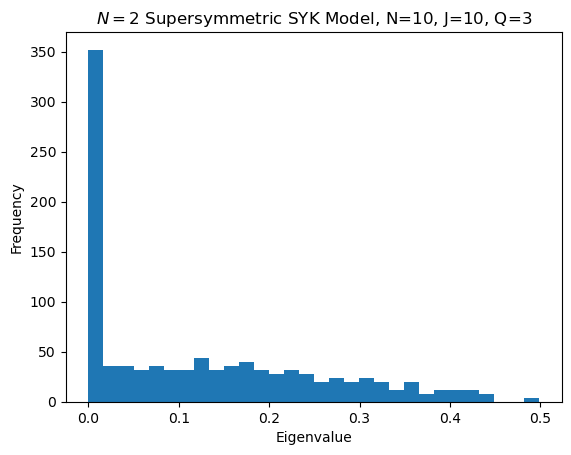

In [20]:
iv = np.linalg.eigvalsh(H.toarray())
iv = np.sort(iv)

plt.figure()
plt.hist(iv, bins=30)
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.title(r"$N=2$ Supersymmetric SYK Model, "+f"N={N}, J={J}, Q={Q_COUPLING}")
plt.savefig(os.path.join(RESULT_DIR, "iv_hist.png"))

Important question: How small is small-enough to consider it "exactly 0"?

## Save everything

In [21]:
# Save eigenvalues
np.save(os.path.join(RESULT_DIR, "iv.npy"), iv)
iv_df = pd.DataFrame({"eigenvalue":iv})
iv_df.to_csv(os.path.join(RESULT_DIR,"iv.csv"), index=False)

In [22]:
# Save Hamiltonian
np.save(os.path.join(RESULT_DIR, "H.npy"), H)
H_df = pd.DataFrame(H.toarray())
H_df.to_csv(os.path.join(RESULT_DIR,"H.csv"), index=False)

In [23]:
# Save Q and Q_bar
np.save(os.path.join(RESULT_DIR, "Q.npy"), Q)
Q_df = pd.DataFrame(Q.toarray())
Q_df.to_csv(os.path.join(RESULT_DIR, "Q.csv"), index=False)

np.save(os.path.join(RESULT_DIR, "Q_bar.npy"), Q_bar)
Q_bar_df = pd.DataFrame(Q_bar.toarray())
Q_bar_df.to_csv(os.path.join(RESULT_DIR, "Q_bar.csv"), index=False)

In [24]:
# Save C_prime, C
np.save(os.path.join(RESULT_DIR, "C_prime.npy"), C_prime)
C_prime_df = pd.DataFrame(C_prime)
C_prime_df.to_csv(os.path.join(RESULT_DIR, "C_prime.csv"), index=False)

np.save(os.path.join(RESULT_DIR, "C.npy"), C)
C_dir = os.path.join(RESULT_DIR, "C")
os.makedirs(C_dir, exist_ok=True)
for i in range(N):
    C_i = C[i]
    C_i_dict_temp = {f"C_ij{k+1}": C_i[:,k] for k in range(N)}
    C_i_dict = {"j":list(range(1,N+1))}
    C_i_dict.update(C_i_dict_temp)
    C_i_df = pd.DataFrame(C_i_dict)
    C_i_df.set_index("j", inplace=True)
    C_i_df.to_csv(os.path.join(C_dir, f"C_{i+1}jk.csv"))

In [25]:
about_txt = f"N={N} \nJ={J} \nQ_COUPLING={Q_COUPLING}"
with open(os.path.join(RESULT_DIR, "about.txt"), "w") as f:
    f.write(about_txt)